In [1]:
import os
import random
from collections import Counter, defaultdict, deque
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import albumentations as A
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import models, transforms
from albumentations.pytorch import ToTensorV2
from scipy.ndimage import gaussian_filter1d
import torch.optim as optim
from torchvision import models
from torchvision import transforms

c:\Users\ASUS\anaconda3\envs\venv\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
def load_image_sequences(root_dir):
    sequences = []
    for subject in os.listdir(root_dir):
        subject_path = os.path.join(root_dir, subject)
        if not os.path.isdir(subject_path):
            continue
        for label in os.listdir(subject_path):
            label_path = os.path.join(subject_path, label)
            if not os.path.isdir(label_path):
                continue
            for action in os.listdir(label_path):
                action_path = os.path.join(label_path, action)
                if not os.path.isdir(action_path):
                    continue
                image_paths = sorted(glob(os.path.join(action_path, '*.jpg')))
                if len(image_paths) == 0:
                    continue
                action_name = "_".join(action.split('_')[1:]) if '_' in action else action
                sequences.append({
                    'subject': subject,
                    'label': label,
                    'action': action_name,
                    'image_paths': image_paths
                })
    return sequences

root_dir = 'train'  
sequences = load_image_sequences(root_dir)

fall_sequences = [s for s in sequences if s['label'] == 'fall']
non_fall_sequences = [s for s in sequences if s['label'] == 'non_fall']

train_sequences = fall_sequences + non_fall_sequences

# Verifikasi distribusi label
train_labels = [s['label'] for s in train_sequences]

print("Train label distribution:", Counter(train_labels))

Train label distribution: Counter({'fall': 24, 'non_fall': 24})


In [3]:
def apply_transformations(sequences, transform):
    transformed_sequences = []
    for seq in sequences:
        transformed_images = []
        for img_path in seq['image_paths']:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = np.expand_dims(img, axis=2)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img = np.array(img, dtype=np.uint8)
            augmented_img = transform(transforms.ToPILImage()(img))
            transformed_images.append(augmented_img)

        transformed_sequences.append({
            'subject': seq['subject'],
            'label': seq['label'],
            'action': seq['action'],
            'image_tensors': transformed_images
        })
    return transformed_sequences

augmentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_augmented = apply_transformations(train_sequences, augmentation)

In [4]:
class SingleFrameActionDataset(Dataset):
    def __init__(self, sequences):
        self.data = []

        for seq in sequences:
            label = 1 if seq['label'] == 'fall' else 0
            for img_tensor in seq['image_tensors']:
                self.data.append((img_tensor, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        return image, label

train_single_frame_dataset = SingleFrameActionDataset(train_augmented)

batch_size = 4
train_single_frame_loader = DataLoader(train_single_frame_dataset, batch_size=batch_size, shuffle=True)

for images, labels in train_single_frame_loader:
    #assert images.shape[1:] == (3, 224, 224), f"Shape mismatch in batch: {images.shape}"
    print(f"Batch size: {images.shape[0]}, Image shape: {images.shape[1:]}")
    break

print(f"Total single frame train samples: {len(train_single_frame_dataset)}")

Batch size: 4, Image shape: torch.Size([3, 224, 224])
Total single frame train samples: 4294


In [5]:
import torch
import torch.nn as nn
from torchvision import models


class CBAM(nn.Module):
    def __init__(self, channels, reduction=16):
        super(CBAM, self).__init__()
        # Channel Attention Module
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, kernel_size=1),
            nn.Sigmoid()
        )
        # Spatial Attention Module
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Channel Attention
        ca = self.channel_attention(x)
        x = x * ca
        # Spatial Attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        sa = torch.cat([avg_out, max_out], dim=1)
        sa = self.spatial_attention(sa)
        x = x * sa
        return x


class ResidualCBAMBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualCBAMBlock, self).__init__()
        self.cbam = CBAM(channels)
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.cbam(x)
        x += residual  # Residual connection
        return x


class MobileNetV3Model(nn.Module):
    def __init__(self, pretrained=True):
        super(MobileNetV3Model, self).__init__()

        # MobileNetV3 Backbone
        self.mobilenet = models.mobilenet_v3_large(pretrained=pretrained)
        num_ftrs_mobilenet = self.mobilenet.classifier[0].in_features
        self.mobilenet.classifier = nn.Identity()  # Remove the classifier

        # Residual CBAM Block
        self.residual_cbam_block = ResidualCBAMBlock(channels=num_ftrs_mobilenet)

        # Simplified Classifier
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs_mobilenet, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)  # Output layer for binary classification
        )

    def forward(self, x):
        # Extract features from backbone
        mobilenet_features = self.mobilenet.features(x)

        # Apply Residual CBAM Block
        mobilenet_features = self.residual_cbam_block(mobilenet_features)

        # Global Average Pooling
        mobilenet_features = nn.AdaptiveAvgPool2d((1, 1))(mobilenet_features)

        # Flatten and pass through classifier
        mobilenet_features = torch.flatten(mobilenet_features, 1)
        output = self.classifier(mobilenet_features)
        return output


# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Model, Loss Function, Optimizer, Scheduler
model = MobileNetV3Model(pretrained=True).to(device)

# Label Smoothing Loss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

c:\Users\ASUS\anaconda3\envs\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Loop pelatihan (contoh dengan 1 epoch)
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_single_frame_loader:  # Pastikan loader untuk single frame digunakan
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_single_frame_loader)
    epoch_accuracy = 100 * correct_train / total_train
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Update learning rate dengan scheduler
    scheduler.step()

Epoch [1/3], Loss: 0.5173, Accuracy: 78.34%
Epoch [2/3], Loss: 0.3956, Accuracy: 89.05%
Epoch [3/3], Loss: 0.3542, Accuracy: 92.08%


In [7]:
from PIL import Image

class TestingDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Dataset untuk pengujian single frame dengan memuat semua gambar dari direktori.

        Args:
            image_dir (str): Path ke direktori yang berisi gambar uji.
            transform (callable, optional): Transformasi opsional untuk diterapkan pada sampel.
        """
        self.image_paths = glob(os.path.join(image_dir, '*'))  # Mendukung format gambar umum
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = -1  # Placeholder karena label tidak tersedia

        # Membaca gambar dalam format grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Gambar tidak ditemukan atau tidak dapat dibaca: {img_path}")

        # Konversi grayscale ke RGB
        img = np.expand_dims(img, axis=2)  # [H, W, 1]
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # [H, W, 3]
        img = np.array(img, dtype=np.uint8)

        # Konversi numpy array ke PIL.Image
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)  # [C, H, W]

        return img, label, img_path

# Path direktori test
test_directory = 'test'  
testing_dataset = TestingDataset(image_dir=test_directory, transform=test_transform)
testing_loader = DataLoader(testing_dataset, batch_size=1, shuffle=False)

Predictions saved to predictions_single_frame9.csv


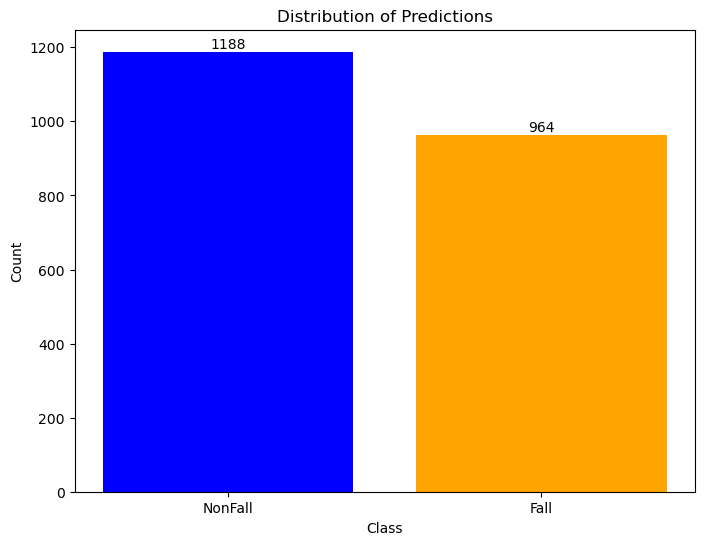

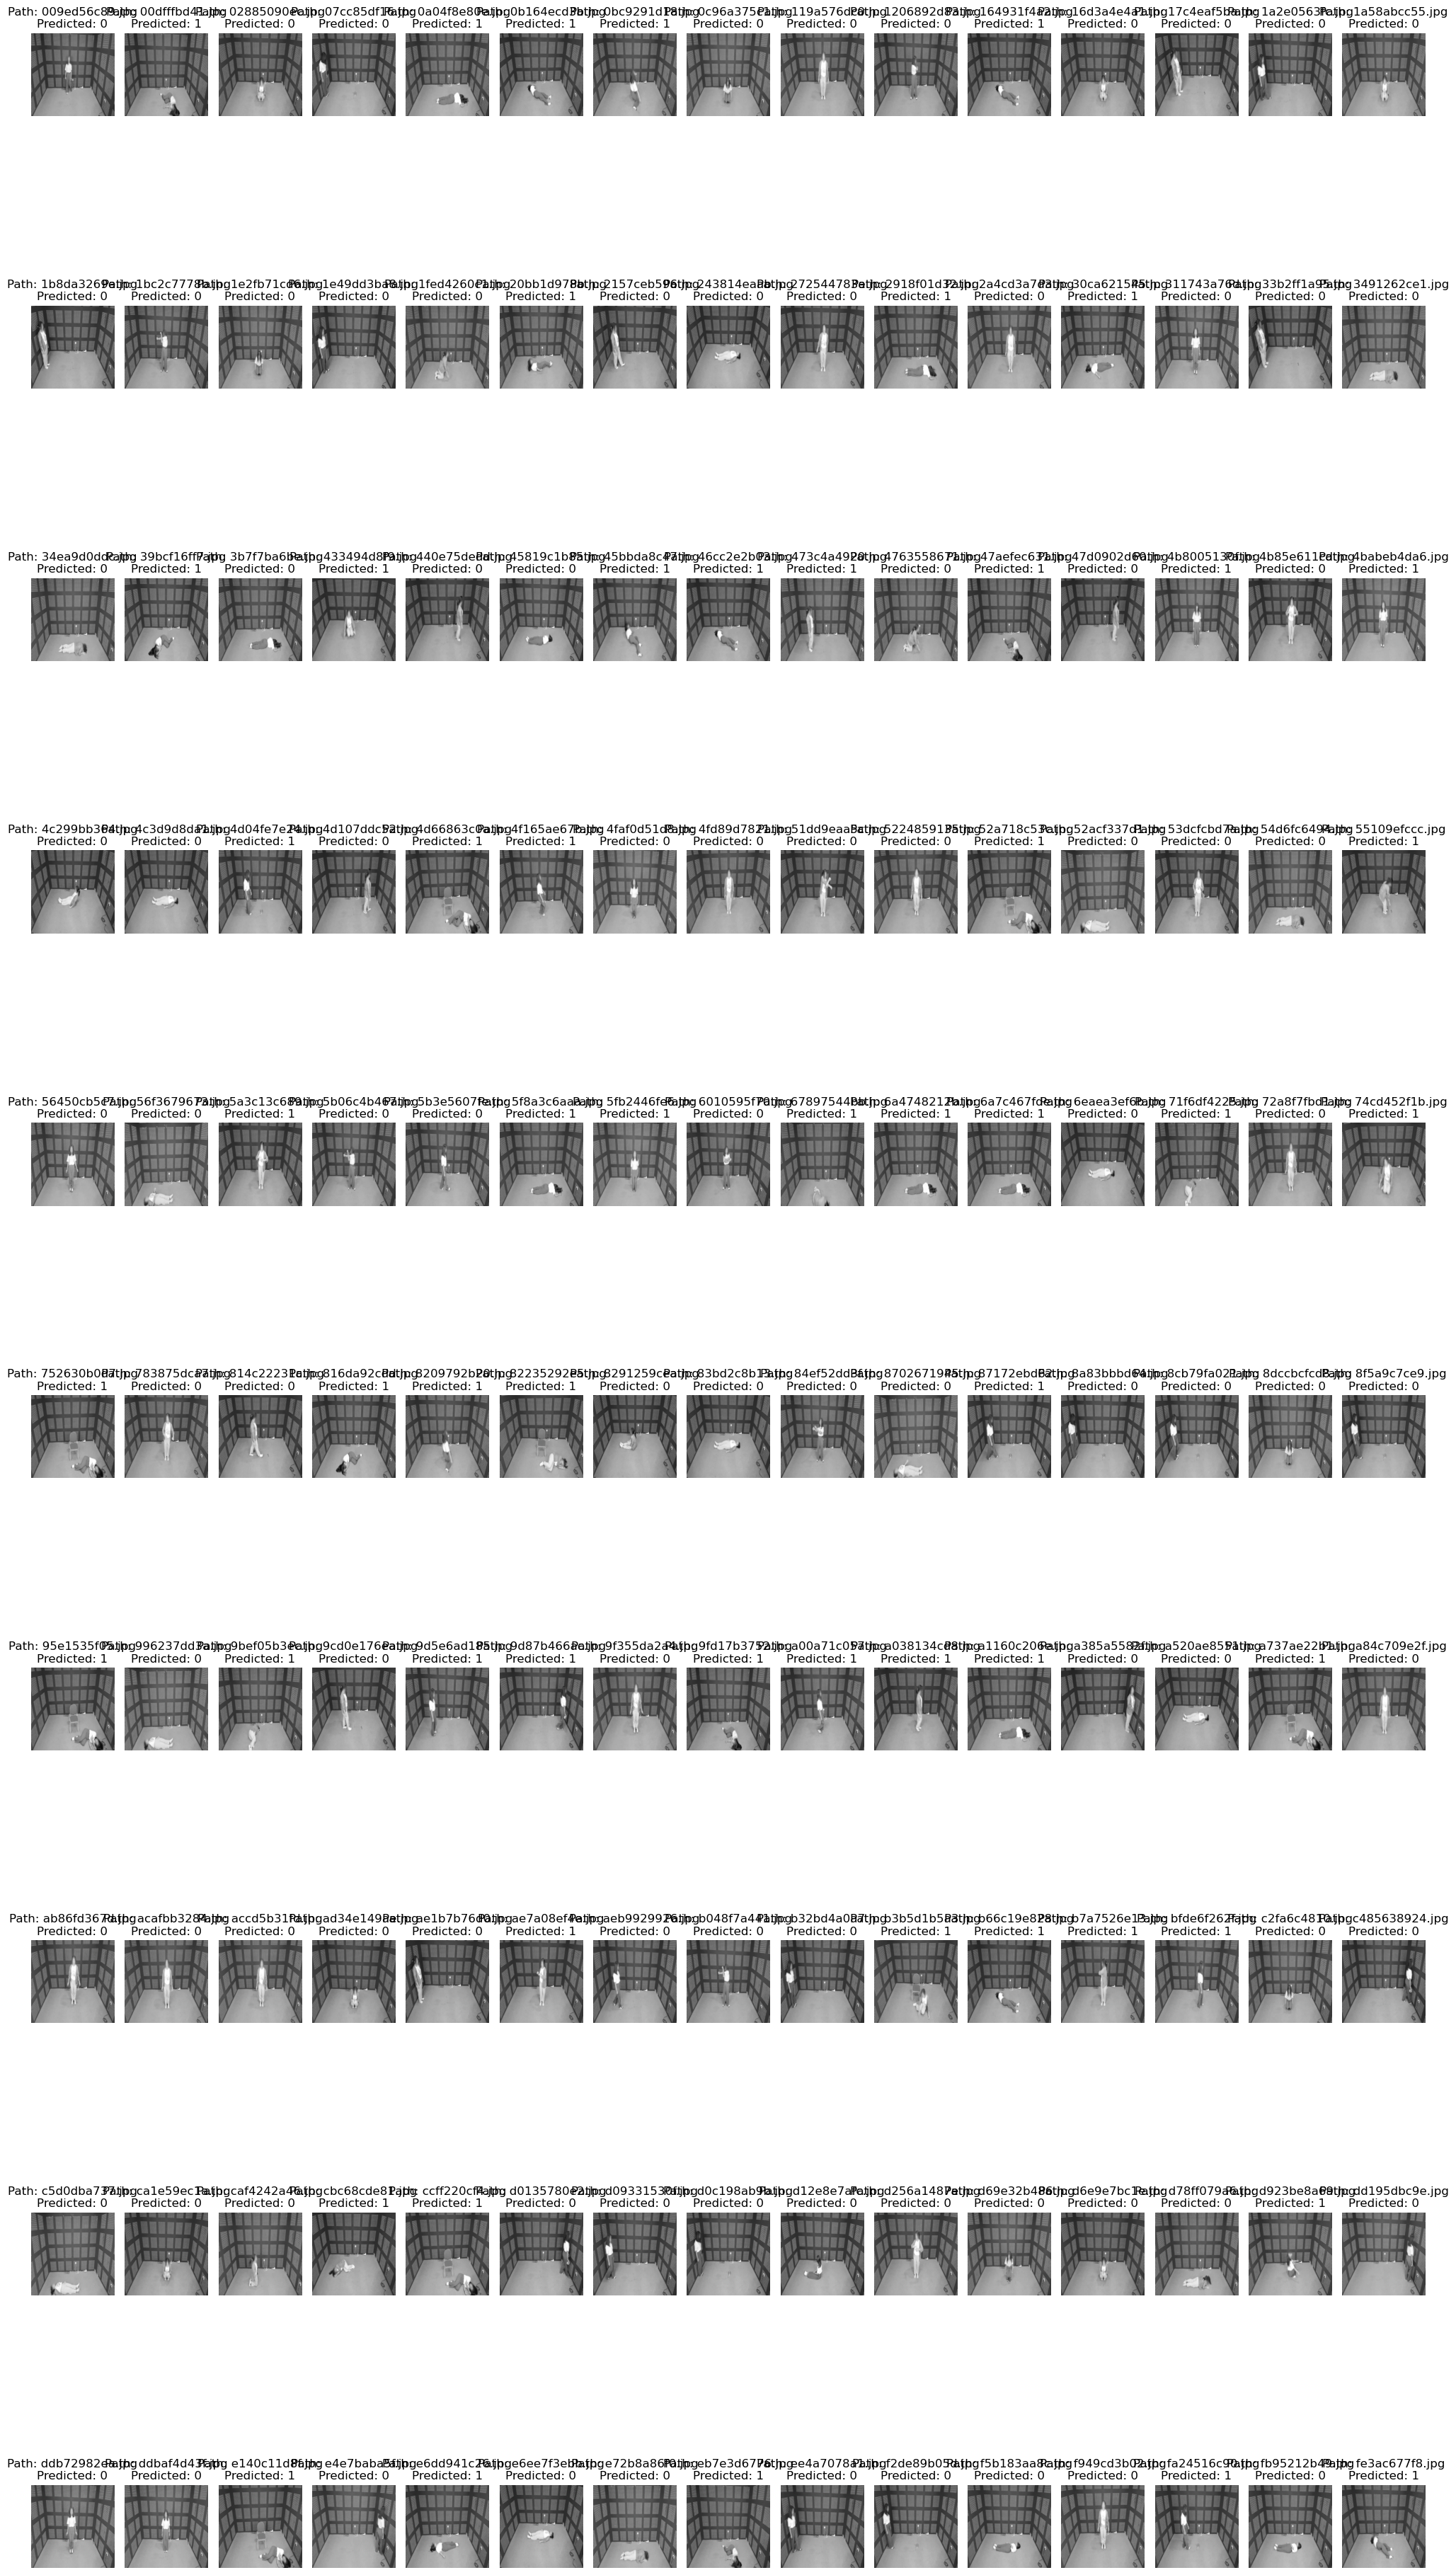

In [8]:
def evaluate_testing(model, testing_loader, device, num_samples=150, csv_path='predictions_single_frame.csv'):
    """
    Evaluates the model on the testing dataset, visualizes random samples, and saves predictions to CSV.

    Args:
        model (torch.nn.Module): Trained PyTorch model.
        testing_loader (DataLoader): DataLoader for the testing dataset.
        device (torch.device): Device to perform computations on.
        num_samples (int): Number of random samples to visualize.
        csv_path (str): Path to save the CSV file with predictions.
    """
    model.eval()

    all_preds = []
    all_paths = []

    sample_images = []
    sample_preds = []
    sample_paths = []

    total_samples = len(testing_loader.dataset)
    num_samples = min(num_samples, total_samples)
    random_indices = set(random.sample(range(total_samples), num_samples))

    with torch.no_grad():
        for batch_idx, (images, _, img_paths) in enumerate(testing_loader):
            # Move data to the specified device
            images = images.to(device)
            
            # Get model predictions
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            pred_label = predicted.item()

            img_path = img_paths[0]
            img_filename = os.path.basename(img_path)

            all_preds.append(pred_label)
            all_paths.append(img_filename)

            # Collect random samples for visualization
            if batch_idx in random_indices and len(sample_images) < num_samples:
                img = images[0].cpu().numpy()
                img = np.transpose(img, (1, 2, 0))  # [H, W, C]
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
                img = np.clip(img, 0, 1)
                sample_images.append(img)
                sample_preds.append(pred_label)
                sample_paths.append(img_filename)

    # Save predictions to CSV
    df = pd.DataFrame({
        'id': all_paths,
        'label': all_preds
    })
    df.to_csv(csv_path, index=False)
    print(f'Predictions saved to {csv_path}')
    
    # Plot distribution of predictions
    distribution = df['label'].value_counts().sort_index()
    labels = ['NonFall', 'Fall']
    counts = distribution.tolist()
    plt.figure(figsize=(8, 6))
    plt.bar(labels, counts, color=['blue', 'orange'])
    plt.title('Distribution of Predictions')
    plt.xlabel('Class')
    plt.ylabel('Count')
    for i, count in enumerate(counts):
        plt.text(i, count, str(count), ha='center', va='bottom')
    plt.show()

    # Visualize random samples
    num_plots = len(sample_images)
    cols = 15  # Update columns to 15 to fit more images per row (for 150 images, 15 x 10 grid)
    rows = (num_plots + cols - 1) // cols  # Calculate rows needed to fit images

    fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
    axes = axes.flatten()

    for i in range(num_plots):
        axes[i].imshow(sample_images[i])
        axes[i].set_title(f'Path: {sample_paths[i]}\nPredicted: {sample_preds[i]}')
        axes[i].axis('off')

    for i in range(num_plots, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Evaluate the model using the single frame test set
evaluate_testing(model, testing_loader, device, num_samples=150, csv_path='predictions_single_frame9.csv')

In [9]:
predictions_path = "predictions_single_frame9.csv"
sample_submission_path = "sample_submission.csv"
merged_output_path = "MeP1F9.csv"

predictions = pd.read_csv(predictions_path)

sample_submission = pd.read_csv(sample_submission_path)
merged = pd.merge(sample_submission, predictions, on='id', how='inner')

merged = merged[['id', 'label_y']].rename(columns={'label_y': 'label'})
merged.to_csv(merged_output_path, index=False)

print(f'Merged CSV saved to {merged_output_path}')

Merged CSV saved to MeP1F9.csv
